In [1]:
import numpy as np 
import warnings
from tabulate import tabulate
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from itertools import cycle
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix ,classification_report
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import RandomOverSampler
import scipy.sparse
from scipy.stats import zscore
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from scipy.stats import kruskal
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.exceptions import ConvergenceWarning
import warnings

In [2]:
def evaluate_classifiers(classifiers, X_train, X_test, y_train, y_test):
    results = []
    
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)
        
        class_results = []
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_score[:, i])
            class_auc = auc(fpr, tpr)
            class_results.append(class_auc)
        
        macro_avg = np.mean(class_results)
        results.append({
            'Classifier': name,
            'Macro-Avg AUC': macro_avg,
            'Class AUCs': class_results
        })
    
    return pd.DataFrame(results)

In [3]:
major_data_final = pd.ExcelFile("balanced_dataset.xlsx")  
print(major_data_final.sheet_names)

['Sheet1']


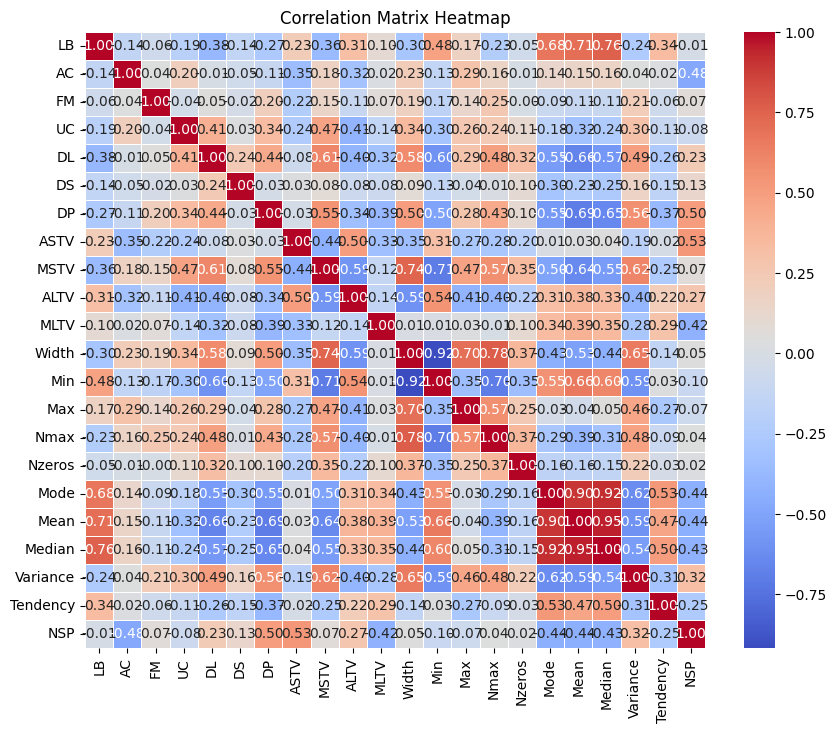

In [4]:
file_path = "balanced_dataset.xlsx"  
df = pd.read_excel(file_path, sheet_name=0)  

corr_matrix = df.corr()

corr_matrix.to_excel("correlation_matrix.xlsx")

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [5]:
X_resampled = df.drop('NSP', axis=1) 
y_resampled = df['NSP']              

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.3, random_state=42, stratify=y_resampled)

print("Training set:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print("\nTest set:")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Training set:
X_train shape: (3475, 21), y_train shape: (3475,)

Test set:
X_test shape: (1490, 21), y_test shape: (1490,)


Best n_estimators: 90 with Accuracy: 0.9919
All Accuracies: [0.9885906040268456, 0.9879194630872483, 0.9899328859060402, 0.991275167785235, 0.991275167785235, 0.9906040268456375, 0.991275167785235, 0.991275167785235, 0.9919463087248322, 0.991275167785235, 0.991275167785235, 0.991275167785235, 0.991275167785235, 0.9906040268456375, 0.9899328859060402, 0.9899328859060402, 0.9899328859060402, 0.9906040268456375, 0.9899328859060402, 0.9892617449664429, 0.9899328859060402, 0.9899328859060402, 0.9906040268456375, 0.9899328859060402, 0.9906040268456375, 0.9906040268456375, 0.9906040268456375, 0.9906040268456375, 0.9899328859060402, 0.9906040268456375, 0.9899328859060402]


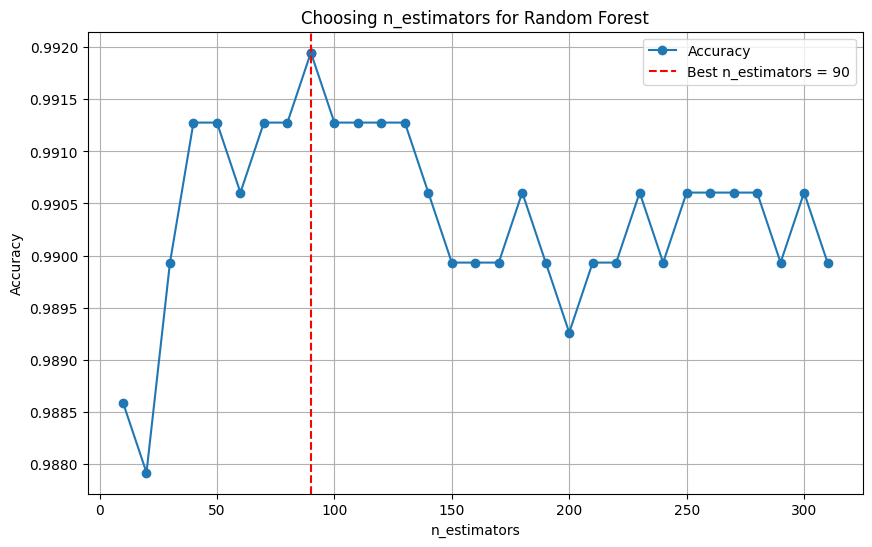

In [6]:
n_est_range = range(10, 320, 10)
accuracies = []

for n in n_est_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

best_index = max(range(len(accuracies)), key=lambda i: accuracies[i])
best_n = n_est_range[best_index]
best_acc = accuracies[best_index]

print(f"Best n_estimators: {best_n} with Accuracy: {best_acc:.4f}")
print("All Accuracies:", accuracies)

plt.figure(figsize=(10, 6))
plt.plot(n_est_range, accuracies, marker='o', label='Accuracy')
plt.axvline(best_n, color='red', linestyle='--', label=f'Best n_estimators = {best_n}')
plt.scatter(best_n, best_acc, color='red')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Choosing n_estimators for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

Best max_depth: 19 with Validation Accuracy: 0.9845


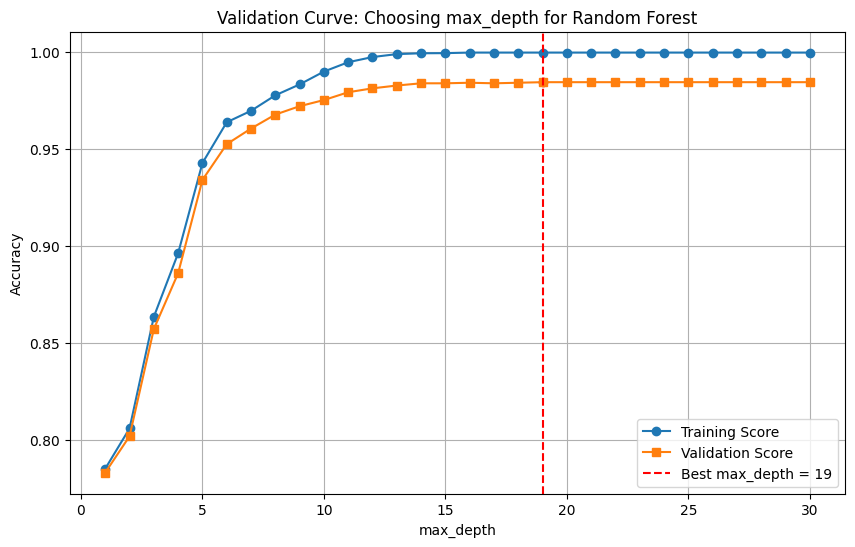

In [7]:
depth_range = np.arange(1, 31)

train_scores, valid_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train, y_train,
    param_name='max_depth',
    param_range=depth_range,
    cv=5,
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

max_val_acc = np.max(valid_mean)
best_index = np.where(valid_mean == max_val_acc)[0][0]
best_depth = depth_range[best_index]

print(f"Best max_depth: {best_depth} with Validation Accuracy: {max_val_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(depth_range, train_mean, label='Training Score', marker='o')
plt.plot(depth_range, valid_mean, label='Validation Score', marker='s')
plt.axvline(best_depth, color='red', linestyle='--', label=f'Best max_depth = {best_depth}')
plt.scatter(best_depth, max_val_acc, color='red')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Validation Curve: Choosing max_depth for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

Best min_samples_split (smallest with highest val accuracy): 3
Validation Accuracy at this value: 0.9856


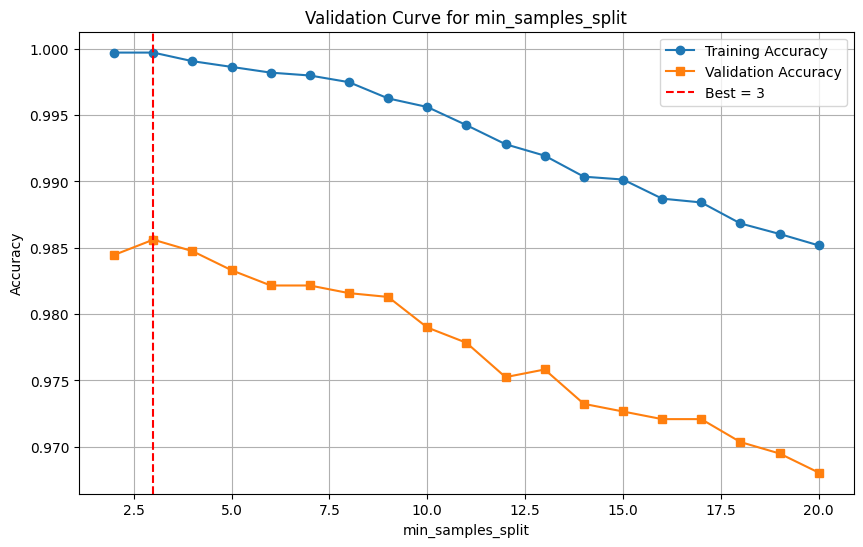

In [8]:
split_range = np.arange(2, 21)

train_scores, valid_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train, y_train,
    param_name='min_samples_split',
    param_range=split_range,
    cv=5,
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

max_val_acc = np.max(valid_mean)
best_index = np.where(valid_mean == max_val_acc)[0][0]
best_split = split_range[best_index]

print(f"Best min_samples_split (smallest with highest val accuracy): {best_split}")
print(f"Validation Accuracy at this value: {max_val_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(split_range, train_mean, label='Training Accuracy', marker='o')
plt.plot(split_range, valid_mean, label='Validation Accuracy', marker='s')
plt.axvline(best_split, color='red', linestyle='--', label=f'Best = {best_split}')
plt.scatter(best_split, max_val_acc, color='red')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Validation Curve for min_samples_split')
plt.legend()
plt.grid(True)
plt.show()

Best min_samples_leaf (smallest with highest validation accuracy): 1
Validation Accuracy at this value: 0.9845


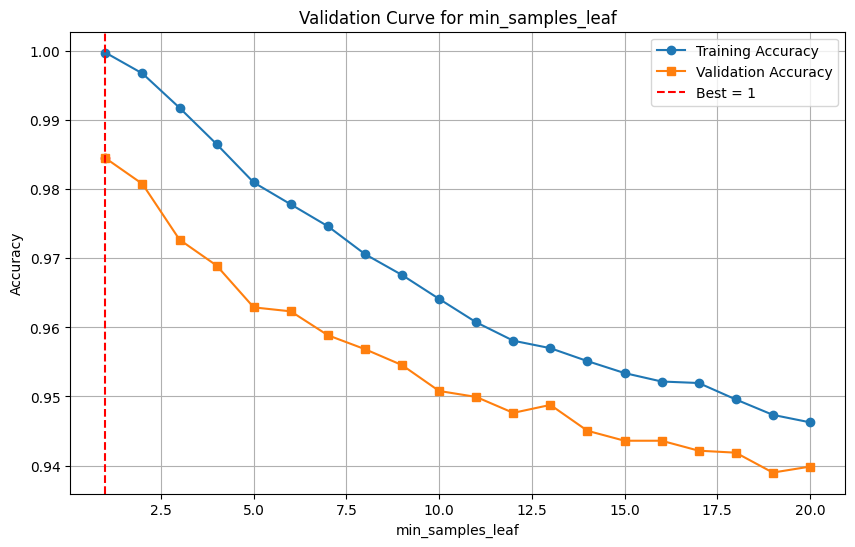

In [9]:
leaf_range = np.arange(1, 21)

train_scores, valid_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train, y_train,
    param_name='min_samples_leaf',
    param_range=leaf_range,
    cv=5,
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

max_val_acc = np.max(valid_mean)
best_index = np.where(valid_mean == max_val_acc)[0][0]
best_leaf = leaf_range[best_index]

print(f"Best min_samples_leaf (smallest with highest validation accuracy): {best_leaf}")
print(f"Validation Accuracy at this value: {max_val_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(leaf_range, train_mean, label='Training Accuracy', marker='o')
plt.plot(leaf_range, valid_mean, label='Validation Accuracy', marker='s')
plt.axvline(best_leaf, color='red', linestyle='--', label=f'Best = {best_leaf}')
plt.scatter(best_leaf, max_val_acc, color='red')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.title('Validation Curve for min_samples_leaf')
plt.grid(True)
plt.legend()
plt.show()

Best max_features (smallest with highest val accuracy): 0.10
Validation Accuracy at this value: 0.9862


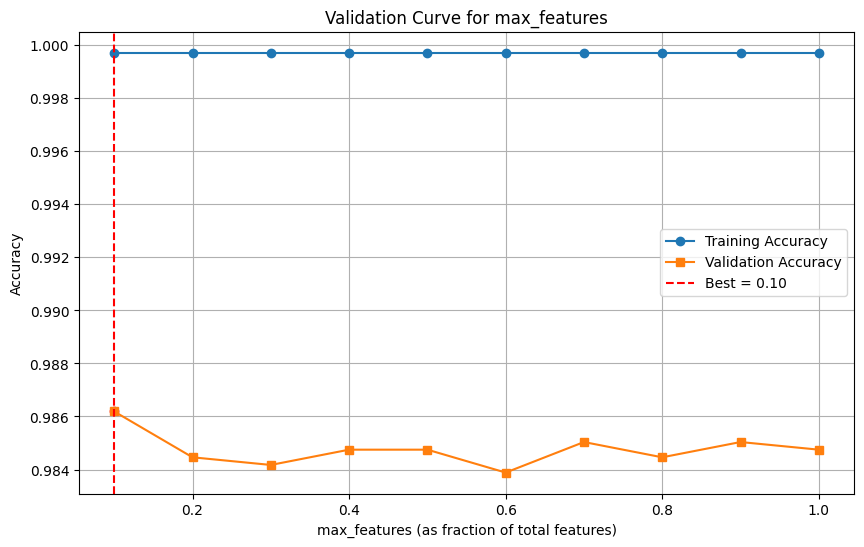

In [10]:
features_range = np.linspace(0.1, 1.0, 10)

train_scores, valid_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train, y_train,
    param_name='max_features',
    param_range=features_range,
    cv=5,
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

max_val_acc = np.max(valid_mean)
best_index = np.where(valid_mean == max_val_acc)[0][0]
best_features = features_range[best_index]

print(f"Best max_features (smallest with highest val accuracy): {best_features:.2f}")
print(f"Validation Accuracy at this value: {max_val_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(features_range, train_mean, label='Training Accuracy', marker='o')
plt.plot(features_range, valid_mean, label='Validation Accuracy', marker='s')
plt.axvline(best_features, color='red', linestyle='--', label=f'Best = {best_features:.2f}')
plt.scatter(best_features, max_val_acc, color='red')
plt.xlabel('max_features (as fraction of total features)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for max_features')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
rf_model = RandomForestClassifier(
    n_estimators=90,         
    max_depth=19,             
    min_samples_split=3,      
    min_samples_leaf=1,       
    max_features=0.10,         
    random_state=42,          
    n_jobs=-1,                
    oob_score=True,           
    bootstrap=True            
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

if hasattr(rf_model, 'oob_score_'):
    print(f"OOB Score: {rf_model.oob_score_:.4f}")


Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.97      0.98       496
           2       0.97      0.99      0.98       497
           3       1.00      1.00      1.00       497

    accuracy                           0.99      1490
   macro avg       0.99      0.99      0.99      1490
weighted avg       0.99      0.99      0.99      1490

OOB Score: 0.9868


Length of y_test: 1490
Length of y_pred: 1490


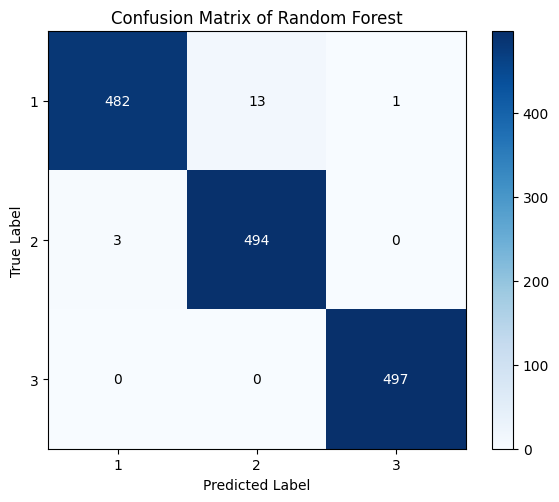

In [12]:
y_pred = rf_model.predict(X_test)

print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred))

if len(y_test) != len(y_pred):
    raise ValueError("Mismatch between y_test and y_pred lengths")

cm = confusion_matrix(y_test, y_pred)

labels = np.unique(y_test)  

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix of Random Forest")
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.grid(False)
plt.show()


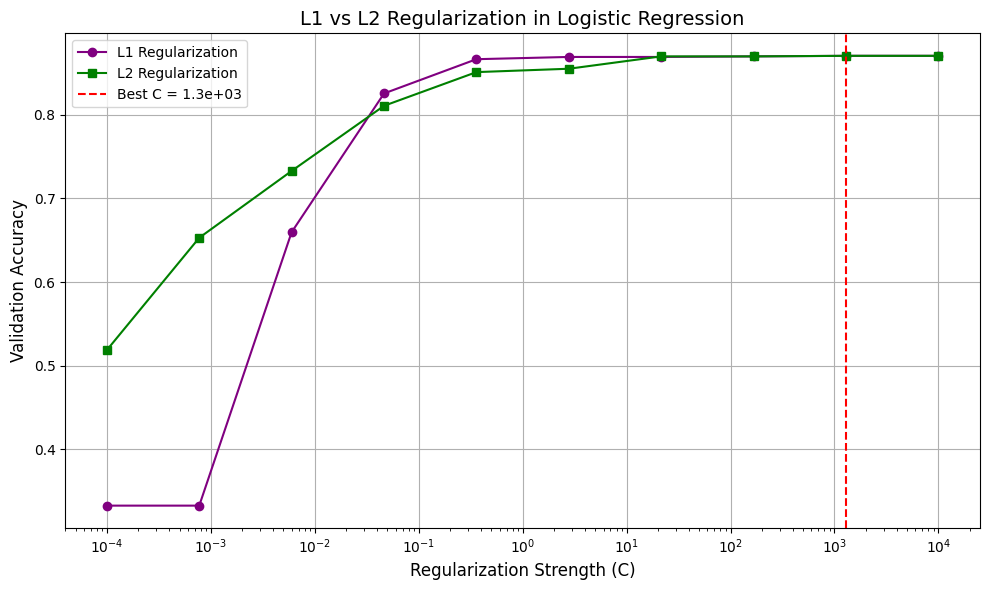

In [13]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

C_values = np.logspace(-4, 4, 10)

l1_scores = []
l2_scores = []

for C in C_values:
    try:
        model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=C, max_iter=1000)
        model_l1.fit(X_train, y_train)
        l1_scores.append(accuracy_score(y_test, model_l1.predict(X_test)))
    except:
        l1_scores.append(np.nan)

    model_l2 = LogisticRegression(penalty='l2', solver='liblinear', C=C, max_iter=1000)
    model_l2.fit(X_train, y_train)
    l2_scores.append(accuracy_score(y_test, model_l2.predict(X_test)))

l1_scores = np.array(l1_scores)
l2_scores = np.array(l2_scores)

best_l1_idx = np.nanargmax(l1_scores)
best_l2_idx = np.argmax(l2_scores)

plt.figure(figsize=(10, 6))
plt.plot(C_values, l1_scores, marker='o', label='L1 Regularization', color='purple')
plt.plot(C_values, l2_scores, marker='s', label='L2 Regularization', color='green')

best_C = C_values[best_l1_idx] if l1_scores[best_l1_idx] >= l2_scores[best_l2_idx] else C_values[best_l2_idx]
plt.axvline(x=best_C, color='red', linestyle='--', label=f'Best C = {best_C:.1e}')

plt.xscale('log')
plt.xlabel('Regularization Strength (C)', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('L1 vs L2 Regularization in Logistic Regression', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


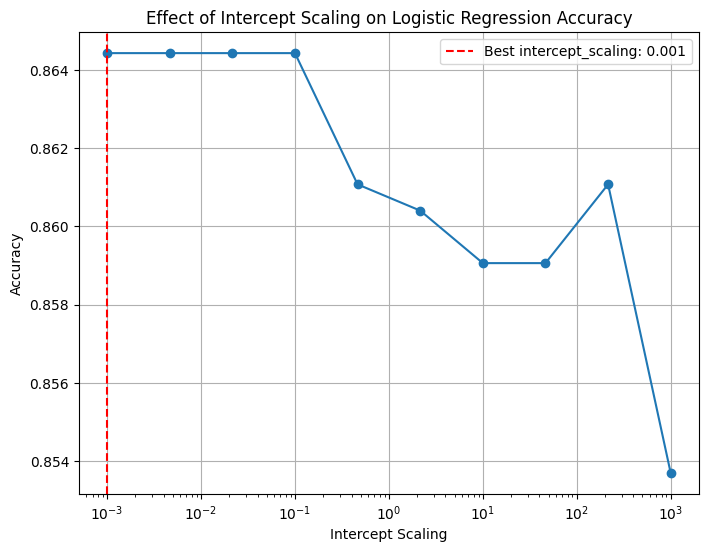

In [14]:
scaling_values = np.logspace(-3, 3, 10)

accuracies = []

for scale in scaling_values:
    model = LogisticRegression(solver='liblinear', intercept_scaling=scale)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

best_scale = scaling_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)

plt.figure(figsize=(8, 6))
plt.plot(scaling_values, accuracies, marker='o')
plt.xscale('log')
plt.xlabel('Intercept Scaling')
plt.ylabel('Accuracy')
plt.title('Effect of Intercept Scaling on Logistic Regression Accuracy')

plt.axvline(x=best_scale, color='r', linestyle='--', label=f'Best intercept_scaling: {best_scale:.3f}')
plt.legend()
plt.grid(True)
plt.show()

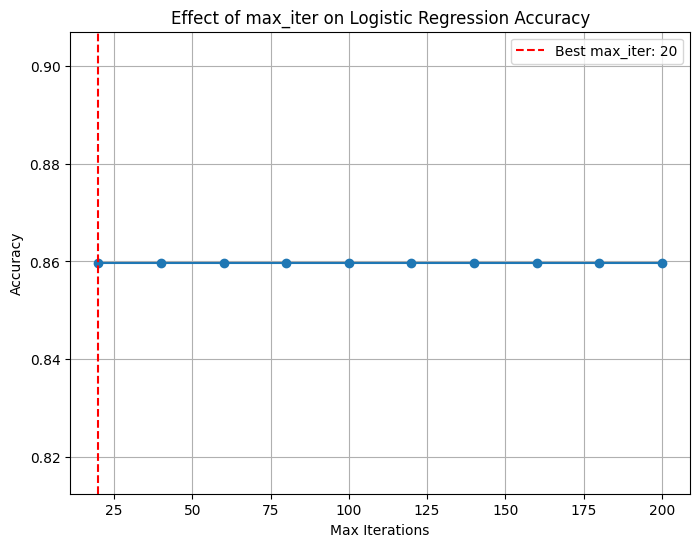

In [15]:
iter_values = np.arange(20, 210, 20)  
accuracies = []

for it in iter_values:
    model = LogisticRegression(solver='liblinear', max_iter=it)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

best_iter = iter_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)

plt.figure(figsize=(8, 6))
plt.plot(iter_values, accuracies, marker='o')
plt.axvline(x=best_iter, color='r', linestyle='--', label=f'Best max_iter: {best_iter}')
plt.xlabel('Max Iterations')
plt.ylabel('Accuracy')
plt.title('Effect of max_iter on Logistic Regression Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
rf_model = RandomForestClassifier(
    n_estimators=60,         
    max_depth=20,             
    min_samples_split=3,      
    min_samples_leaf=1,       
    max_features=0.70,         
    random_state=42,          
    n_jobs=-1,                
    oob_score=True,           
    bootstrap=True            
)

svc_model = SVC(
                kernel='rbf',     
                C=100,             
                degree=3,          
                gamma='scale',     
                coef0=1.11, 
                decision_function_shape='ovo',
                random_state=42
                )

lr_model = LogisticRegression(
    penalty='l2',         
    C=2.2e+01,                
    solver='liblinear',  
    max_iter=20, 
    fit_intercept=True,
    intercept_scaling=10.000,
    class_weight=None,
    multi_class='deprecated', 
    verbose=0, 
    warm_start=False,
    random_state=42
)


voting_clf = VotingClassifier(
    estimators=[('Random Forest', rf_model), ('SVM', svc_model), ('Logistic Regression', lr_model)],
    voting='hard'  
)

voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Voting Classifier Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Voting Classifier Accuracy: 0.97
              precision    recall  f1-score   support

           1       0.99      0.93      0.96       496
           2       0.93      0.99      0.96       497
           3       0.99      0.99      0.99       497

    accuracy                           0.97      1490
   macro avg       0.97      0.97      0.97      1490
weighted avg       0.97      0.97      0.97      1490



Length of y_test: 1490
Length of y_pred: 1490


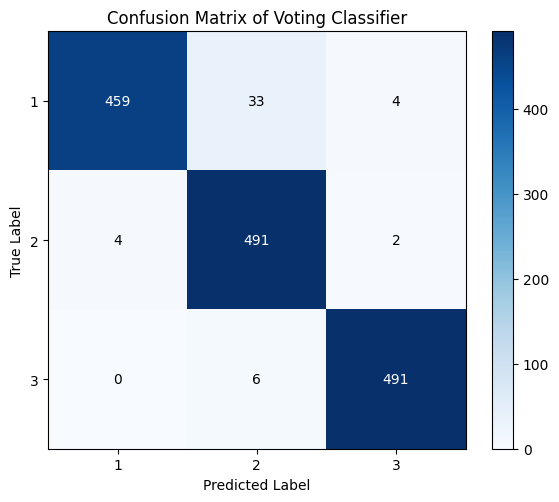

In [17]:
y_pred = voting_clf.predict(X_test)

print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred))

if len(y_test) != len(y_pred):
    raise ValueError("Mismatch between y_test and y_pred lengths")

cm = confusion_matrix(y_test, y_pred)

labels = np.unique(y_test)  

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix of Voting Classifier")
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.grid(False)
plt.show()


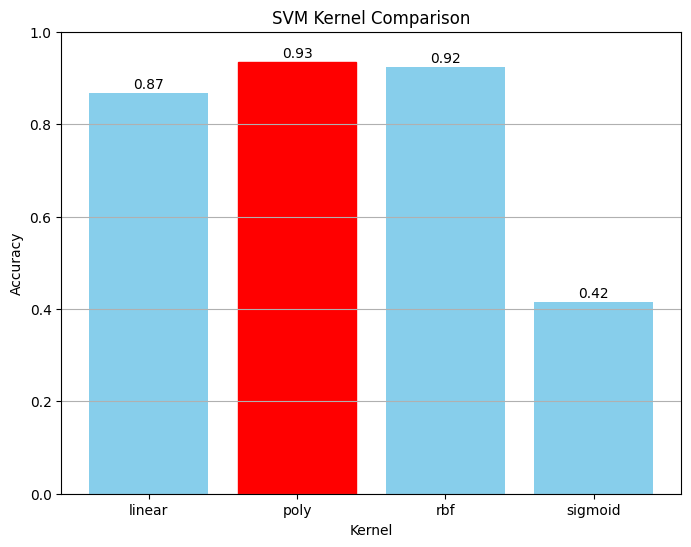

In [18]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
accuracies = []

for kernel in kernels:
    model = SVC(kernel=kernel)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

best_kernel = kernels[np.argmax(accuracies)]
best_accuracy = max(accuracies)

plt.figure(figsize=(8, 6))
bars = plt.bar(kernels, accuracies, color='skyblue')
bars[np.argmax(accuracies)].set_color('red')  
plt.title('SVM Kernel Comparison')
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  
plt.grid(axis='y')

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center')

plt.show()

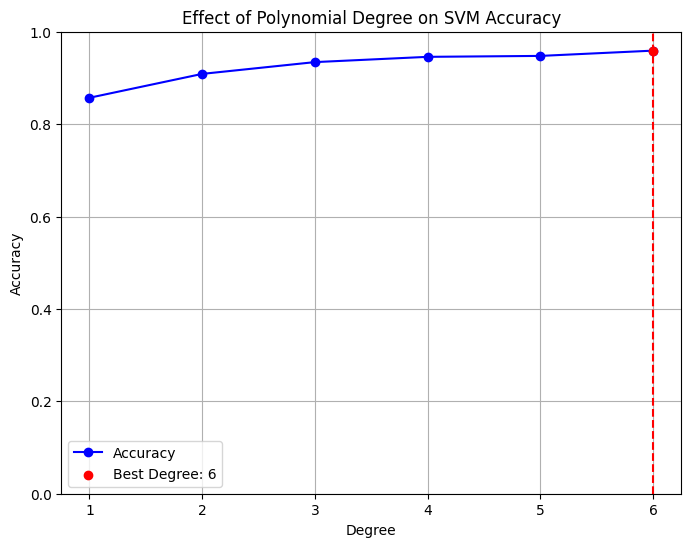

In [19]:
degrees = range(1, 7)
accuracies = []

for d in degrees:
    model = SVC(kernel='poly', degree=d)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

best_degree = degrees[np.argmax(accuracies)]
best_accuracy = max(accuracies)

plt.figure(figsize=(8, 6))
plt.plot(degrees, accuracies, marker='o', linestyle='-', color='blue', label='Accuracy')
plt.scatter([best_degree], [best_accuracy], color='red', zorder=5, label=f'Best Degree: {best_degree}')
plt.axvline(x=best_degree, color='red', linestyle='--')  
plt.title('Effect of Polynomial Degree on SVM Accuracy')
plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(degrees)
plt.grid(True)
plt.legend()
plt.show()


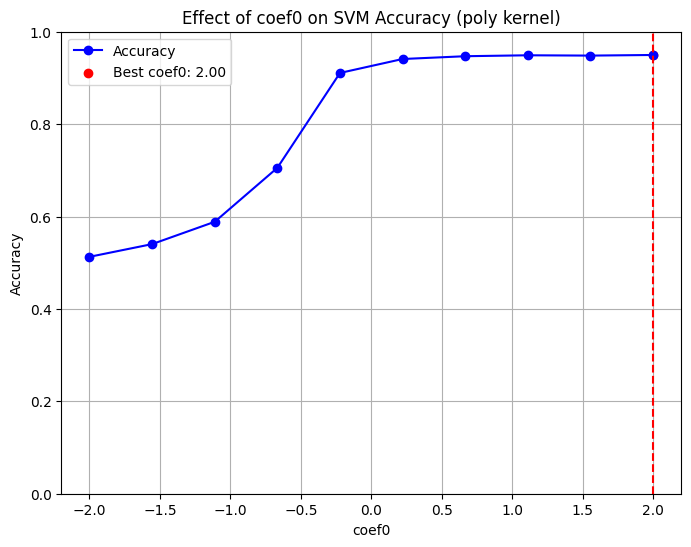

In [20]:
coef0_values = np.linspace(-2, 2, 10)
accuracies = []

for c0 in coef0_values:
    model = SVC(kernel='poly', degree=3, coef0=c0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

best_coef0 = coef0_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)

plt.figure(figsize=(8, 6))
plt.plot(coef0_values, accuracies, marker='o', linestyle='-', color='blue', label='Accuracy')
plt.scatter([best_coef0], [best_accuracy], color='red', label=f'Best coef0: {best_coef0:.2f}')
plt.axvline(x=best_coef0, color='red', linestyle='--')  
plt.title('Effect of coef0 on SVM Accuracy (poly kernel)')
plt.xlabel('coef0')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


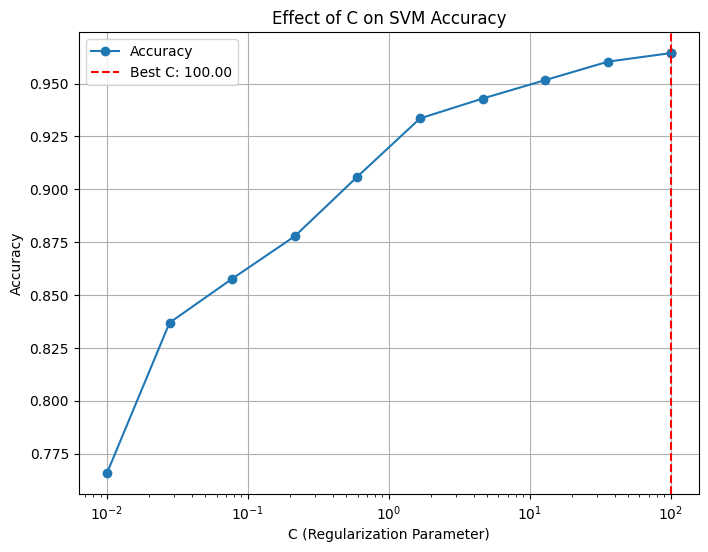

In [21]:
C_values = np.logspace(-2, 2, 10)  
accuracies = []

for c in C_values:
    model = SVC(kernel='rbf', C=c)  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

best_c = C_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)


plt.figure(figsize=(8, 6))
plt.plot(C_values, accuracies, marker='o', label='Accuracy')
plt.axvline(x=best_c, color='red', linestyle='--', label=f'Best C: {best_c:.2f}')
plt.scatter([best_c], [best_accuracy], color='red')
plt.xscale('log')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Accuracy')
plt.title('Effect of C on SVM Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [22]:
model_svm = SVC(
    kernel='poly',     
    C=100,             
    degree=6,          
    gamma='scale',     
    coef0=0.67, 
    decision_function_shape='ovr',
    random_state=42
)

model_svm.fit(X_train, y_train)

y_pred = model_svm.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.96      0.98       496
           2       0.96      1.00      0.98       497
           3       1.00      1.00      1.00       497

    accuracy                           0.99      1490
   macro avg       0.99      0.99      0.99      1490
weighted avg       0.99      0.99      0.99      1490



Length of y_test: 1490
Length of y_pred: 1490


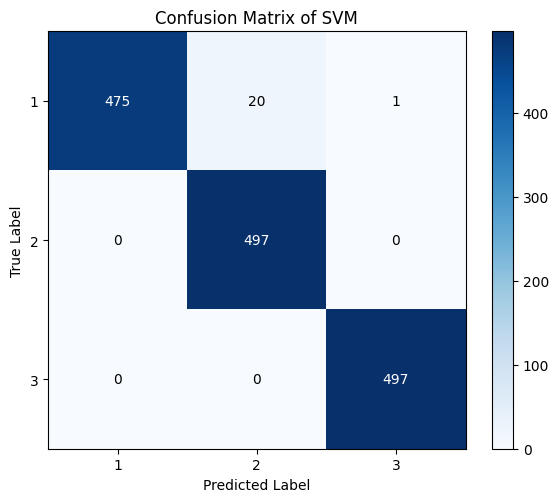

In [23]:
y_pred = model_svm.predict(X_test)

print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred))

if len(y_test) != len(y_pred):
    raise ValueError("Mismatch between y_test and y_pred lengths")

cm = confusion_matrix(y_test, y_pred)

labels = np.unique(y_test)  

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix of SVM")
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.grid(False)
plt.show()


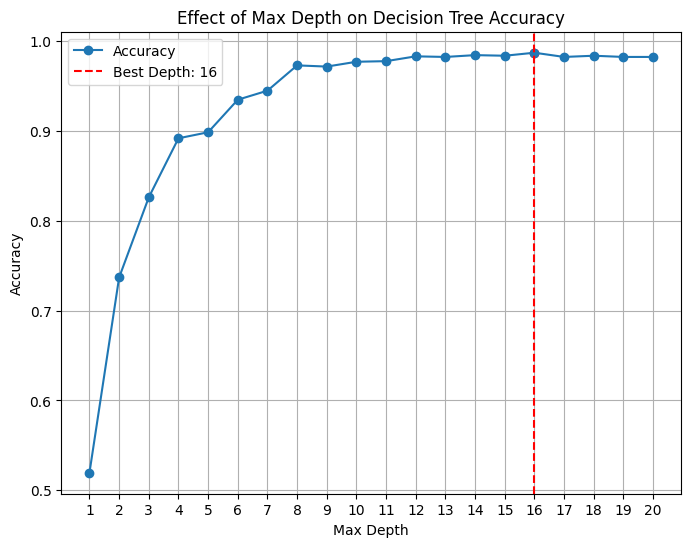

In [24]:
depth_values = range(1, 21)
accuracies = []

for depth in depth_values:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

best_depth = depth_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)

plt.figure(figsize=(8, 6))
plt.plot(depth_values, accuracies, marker='o', label='Accuracy')
plt.axvline(x=best_depth, color='red', linestyle='--', label=f'Best Depth: {best_depth}')
plt.scatter([best_depth], [best_accuracy], color='red')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Effect of Max Depth on Decision Tree Accuracy')
plt.xticks(depth_values)
plt.grid(True)
plt.legend()
plt.show()

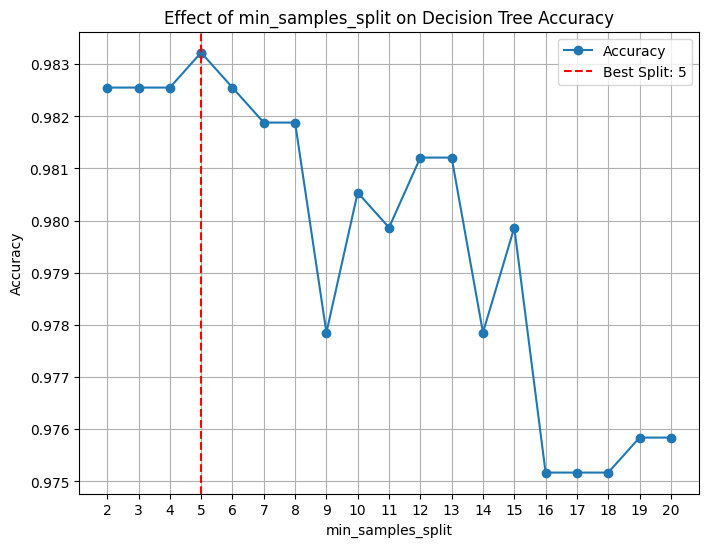

In [25]:
split_values = range(2, 21)  
accuracies = []

for split in split_values:
    model = DecisionTreeClassifier(min_samples_split=split, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

best_split = split_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)

plt.figure(figsize=(8, 6))
plt.plot(split_values, accuracies, marker='o', label='Accuracy')
plt.axvline(x=best_split, color='red', linestyle='--', label=f'Best Split: {best_split}')
plt.scatter([best_split], [best_accuracy], color='red')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Effect of min_samples_split on Decision Tree Accuracy')
plt.xticks(split_values)
plt.grid(True)
plt.legend()
plt.show()


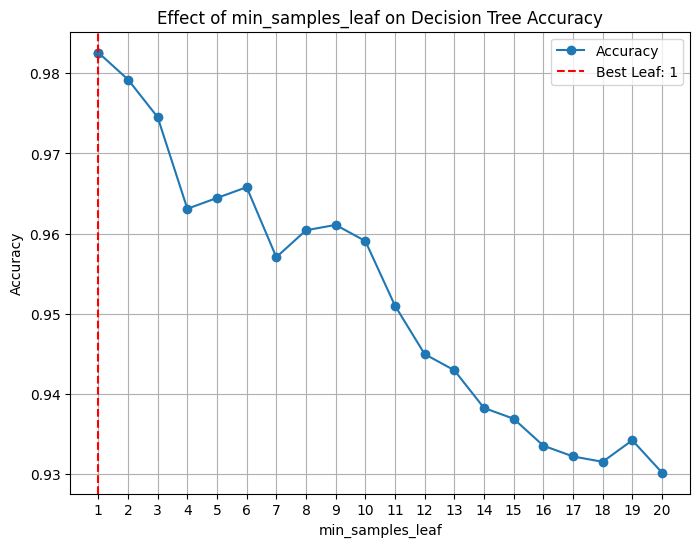

In [26]:
leaf_values = range(1, 21)
accuracies = []

for leaf in leaf_values:
    model = DecisionTreeClassifier(min_samples_leaf=leaf, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

best_leaf = leaf_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)

plt.figure(figsize=(8, 6))
plt.plot(leaf_values, accuracies, marker='o', label='Accuracy')
plt.axvline(x=best_leaf, color='red', linestyle='--', label=f'Best Leaf: {best_leaf}')
plt.scatter([best_leaf], [best_accuracy], color='red')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.title('Effect of min_samples_leaf on Decision Tree Accuracy')
plt.xticks(leaf_values)
plt.grid(True)
plt.legend()
plt.show()

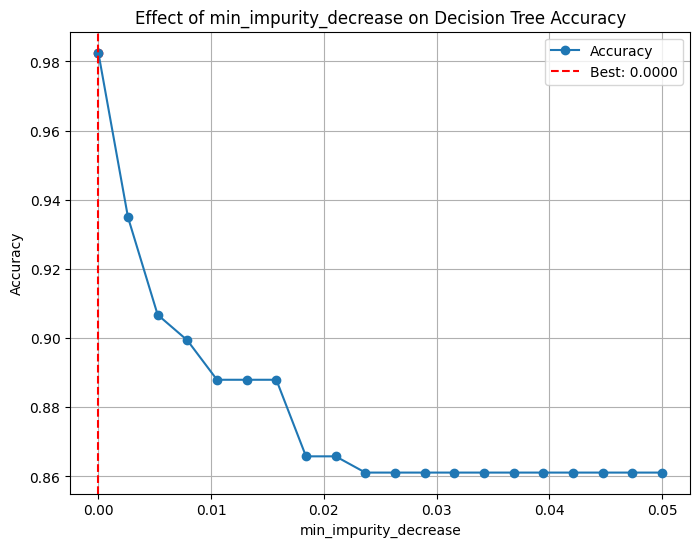

In [27]:
impurity_values = np.linspace(0, 0.05, 20)  
accuracies = []

for val in impurity_values:
    model = DecisionTreeClassifier(min_impurity_decrease=val, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

best_val = impurity_values[np.argmax(accuracies)]
best_acc = max(accuracies)

plt.figure(figsize=(8, 6))
plt.plot(impurity_values, accuracies, marker='o', label='Accuracy')
plt.axvline(x=best_val, color='red', linestyle='--', label=f'Best: {best_val:.4f}')
plt.scatter([best_val], [best_acc], color='red')
plt.xlabel('min_impurity_decrease')
plt.ylabel('Accuracy')
plt.title('Effect of min_impurity_decrease on Decision Tree Accuracy')
plt.grid(True)
plt.legend()
plt.show()


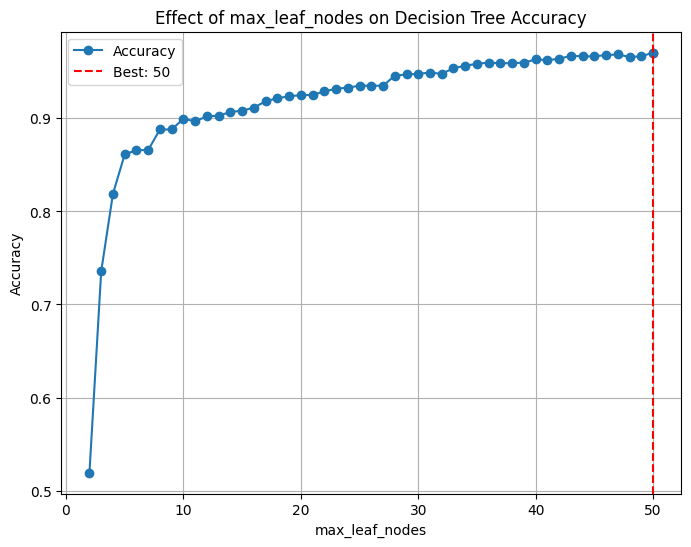

In [28]:
leaf_nodes_range = range(2, 51)  
accuracies = []

for nodes in leaf_nodes_range:
    model = DecisionTreeClassifier(max_leaf_nodes=nodes, random_state=None)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

best_nodes = leaf_nodes_range[np.argmax(accuracies)]
best_acc = max(accuracies)

plt.figure(figsize=(8, 6))
plt.plot(leaf_nodes_range, accuracies, marker='o', label='Accuracy')
plt.axvline(x=best_nodes, color='red', linestyle='--', label=f'Best: {best_nodes}')
plt.scatter([best_nodes], [best_acc], color='red')
plt.xlabel('max_leaf_nodes')
plt.ylabel('Accuracy')
plt.title('Effect of max_leaf_nodes on Decision Tree Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [29]:
model_dt = DecisionTreeClassifier(
    criterion='gini',                 
    splitter='best',                 
    max_depth=17,                  
    min_samples_split=2,            
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,               
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,               
    ccp_alpha=0.0,                   
    monotonic_cst=None             
)

model_dt.fit(X_train, y_train)

y_pred = model_dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9792

Classification Report:

              precision    recall  f1-score   support

           1       1.00      0.95      0.97       496
           2       0.96      0.99      0.97       497
           3       0.98      1.00      0.99       497

    accuracy                           0.98      1490
   macro avg       0.98      0.98      0.98      1490
weighted avg       0.98      0.98      0.98      1490



Length of y_test: 1490
Length of y_pred: 1490


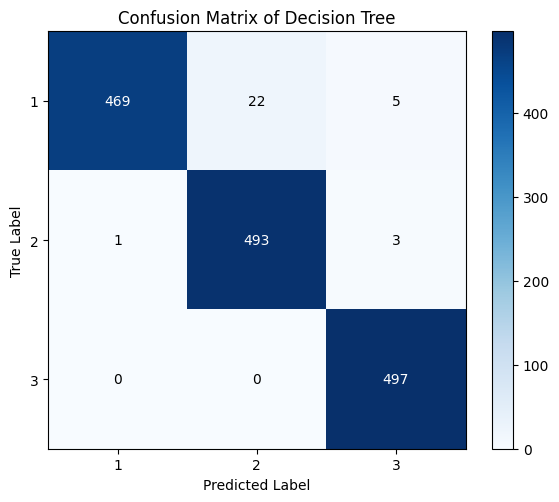

In [30]:
y_pred = model_dt.predict(X_test)

print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred))

if len(y_test) != len(y_pred):
    raise ValueError("Mismatch between y_test and y_pred lengths")

cm = confusion_matrix(y_test, y_pred)

labels = np.unique(y_test)  

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix of Decision Tree")
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.grid(False)
plt.show()


1


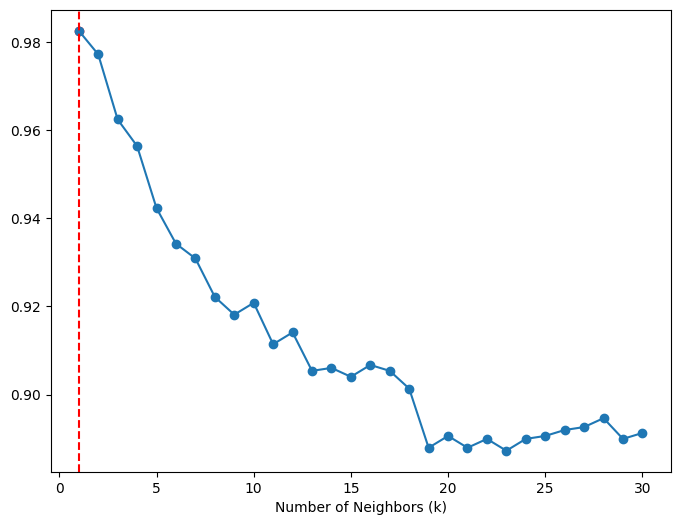

In [31]:
k_values = range(1, 31)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

best_k = k_values[np.argmax(accuracies)]
best_acc = max(accuracies)

plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracies, marker='o', label='Accuracy')
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
plt.scatter([best_k], [best_acc], color='red')
plt.xlabel('Number of Neighbors (k)')
print(best_k)

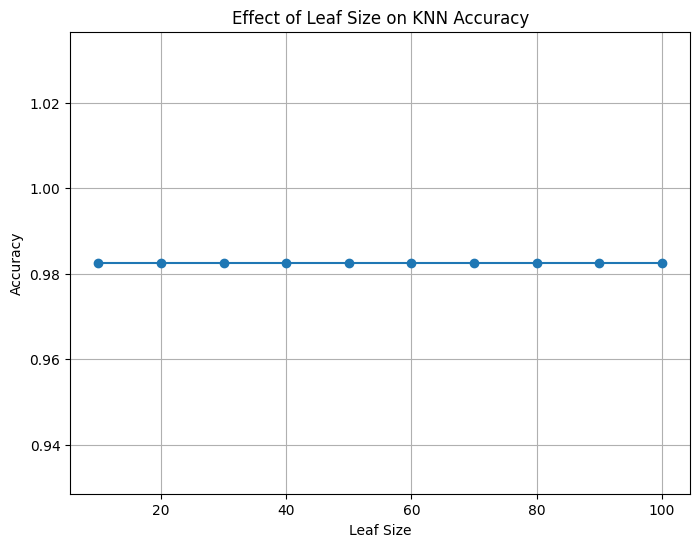

In [32]:
leaf_sizes = range(10, 101, 10)  
accuracies = []

for leaf_size in leaf_sizes:
    knn = KNeighborsClassifier(
        n_neighbors=1,
        weights='uniform',
        algorithm='auto',
        leaf_size=leaf_size,
        p=2,  
        metric='minkowski'
    )
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(8, 6))
plt.plot(leaf_sizes, accuracies, marker='o')
plt.xlabel('Leaf Size')
plt.ylabel('Accuracy')
plt.title('Effect of Leaf Size on KNN Accuracy')
plt.grid(True)
plt.show()

In [33]:
knn = KNeighborsClassifier(
    n_neighbors=1,              
    weights='uniform',          
    algorithm='ball_tree',           
    leaf_size=20,               
    p=1,                        
    metric='minkowski',         
    n_jobs=None                 
)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.9826

Classification Report:

              precision    recall  f1-score   support

           1       1.00      0.95      0.97       496
           2       0.96      1.00      0.98       497
           3       0.99      1.00      0.99       497

    accuracy                           0.98      1490
   macro avg       0.98      0.98      0.98      1490
weighted avg       0.98      0.98      0.98      1490



Length of y_test: 1490
Length of y_pred: 1490


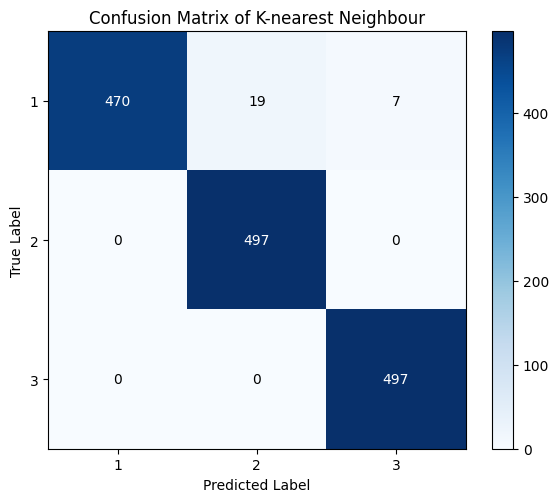

In [34]:
y_pred = knn.predict(X_test)

print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred))

if len(y_test) != len(y_pred):
    raise ValueError("Mismatch between y_test and y_pred lengths")

cm = confusion_matrix(y_test, y_pred)

labels = np.unique(y_test)  

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix of K-nearest Neighbour")
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.grid(False)
plt.show()


C:\Users\Aritro Saha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:11:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Aritro Saha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:11:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Aritro Saha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:11:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_la

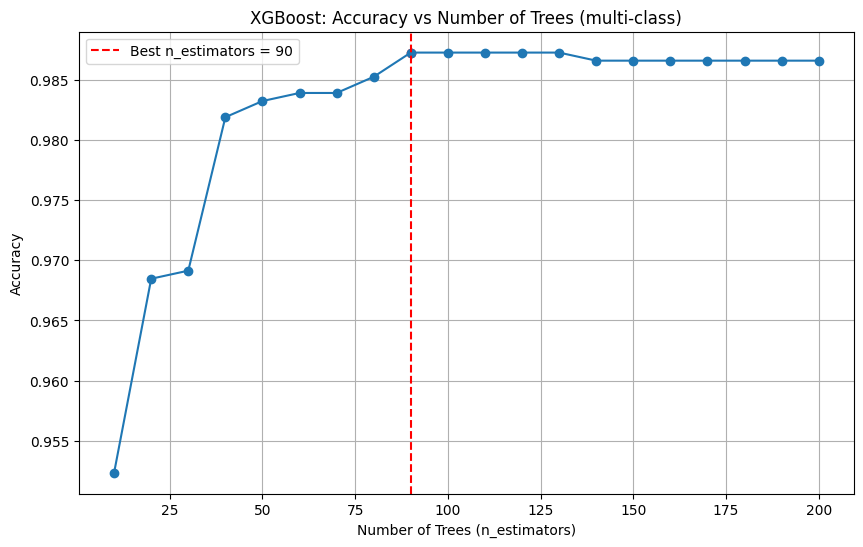

In [35]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

y_resampled = y_resampled + 1

le = LabelEncoder()
y_encoded = le.fit_transform(y_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_encoded, test_size=0.3, random_state=42)

tree_counts = range(10, 201, 10)
accuracies = []

for n in tree_counts:
    model = XGBClassifier(
        n_estimators=n,
        learning_rate=0.1,
        max_depth=6,
        objective='multi:softmax',
        num_class=len(le.classes_),
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )
    model.fit(X_train, y_train)
    
    y_pred_encoded = model.predict(X_test)
    
    y_pred = le.inverse_transform(y_pred_encoded)
    y_test_actual = le.inverse_transform(y_test)
    
    acc = accuracy_score(y_test_actual, y_pred)
    accuracies.append(acc)

plt.figure(figsize=(10, 6))
plt.plot(tree_counts, accuracies, marker='o')
best_index = np.argmax(accuracies)
best_n = tree_counts[best_index]
best_acc = accuracies[best_index]
plt.axvline(best_n, color='red', linestyle='--', label=f'Best n_estimators = {best_n}')
plt.scatter(best_n, best_acc, color='red')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('XGBoost: Accuracy vs Number of Trees (multi-class)')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\Aritro Saha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:12:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Aritro Saha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:12:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Aritro Saha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:12:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_la

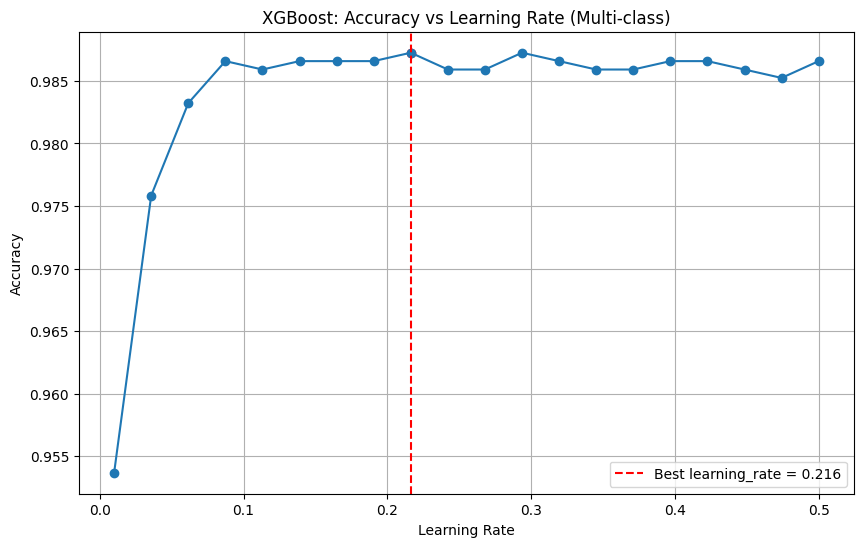

In [36]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

y_resampled = y_resampled + 1

le = LabelEncoder()
y_encoded = le.fit_transform(y_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_encoded, test_size=0.3, random_state=42)

learning_rates = np.linspace(0.01, 0.5, 20)
accuracies = []

for lr in learning_rates:
    model = XGBClassifier(
        n_estimators=100,
        learning_rate=lr,
        max_depth=6,
        objective='multi:softmax',
        num_class=len(le.classes_),
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred_encoded = model.predict(X_test)

    y_pred = le.inverse_transform(y_pred_encoded)
    y_test_actual = le.inverse_transform(y_test)

    acc = accuracy_score(y_test_actual, y_pred)
    accuracies.append(acc)

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, accuracies, marker='o')
best_index = np.argmax(accuracies)
best_lr = learning_rates[best_index]
best_acc = accuracies[best_index]
plt.axvline(best_lr, color='red', linestyle='--', label=f'Best learning_rate = {best_lr:.3f}')
plt.scatter(best_lr, best_acc, color='red')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('XGBoost: Accuracy vs Learning Rate (Multi-class)')
plt.grid(True)
plt.legend()
plt.show()

In [37]:
model_xg = XGBClassifier(
    n_estimators=110,         
    learning_rate=0.139,      
    max_depth=6,              
    subsample=0.8,            
    colsample_bytree=0.8,     
    gamma=0.2,                
    reg_alpha=0.5,            
    reg_lambda=1.0,          
    objective='multi:softmax',
    num_class=len(le.classes_),
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

model_xg.fit(X_train, y_train)

y_pred_encoded = model_xg.predict(X_test)

y_pred = le.inverse_transform(y_pred_encoded)
y_test_actual = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_actual, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", classification_report(y_test_actual, y_pred))

Accuracy: 0.9839

Classification Report:
               precision    recall  f1-score   support

           3       0.99      0.96      0.98       520
           4       0.97      0.99      0.98       485
           5       0.99      1.00      1.00       485

    accuracy                           0.98      1490
   macro avg       0.98      0.98      0.98      1490
weighted avg       0.98      0.98      0.98      1490



C:\Users\Aritro Saha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:12:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Length of y_test: 1490
Length of y_pred: 1490


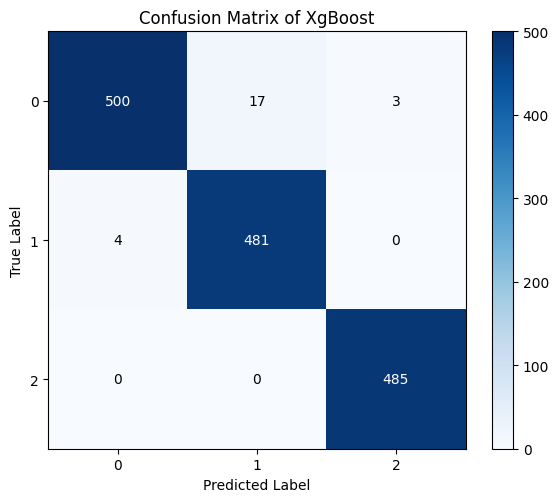

In [38]:
y_pred = model_xg.predict(X_test)

print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred))

if len(y_test) != len(y_pred):
    raise ValueError("Mismatch between y_test and y_pred lengths")

cm = confusion_matrix(y_test, y_pred)

labels = np.unique(y_test)  

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix of XgBoost")
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.grid(False)
plt.show()


C:\Users\Aritro Saha\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:12:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


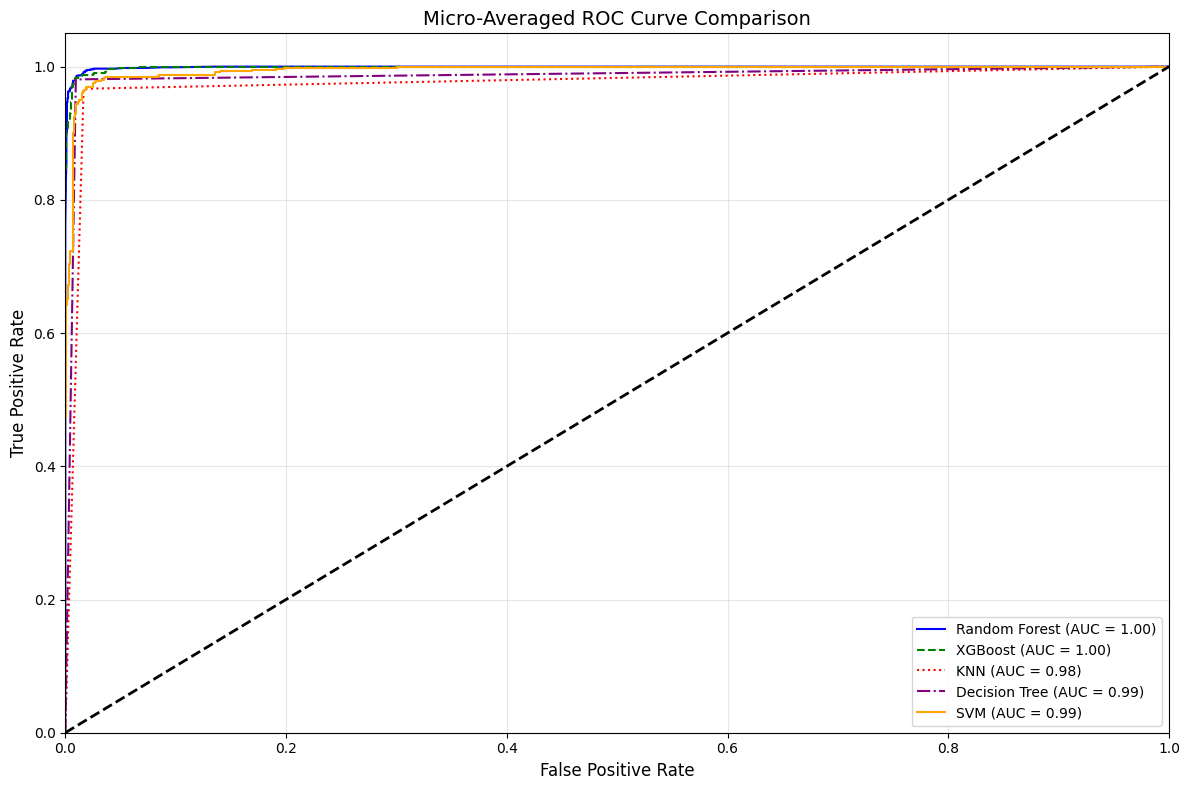

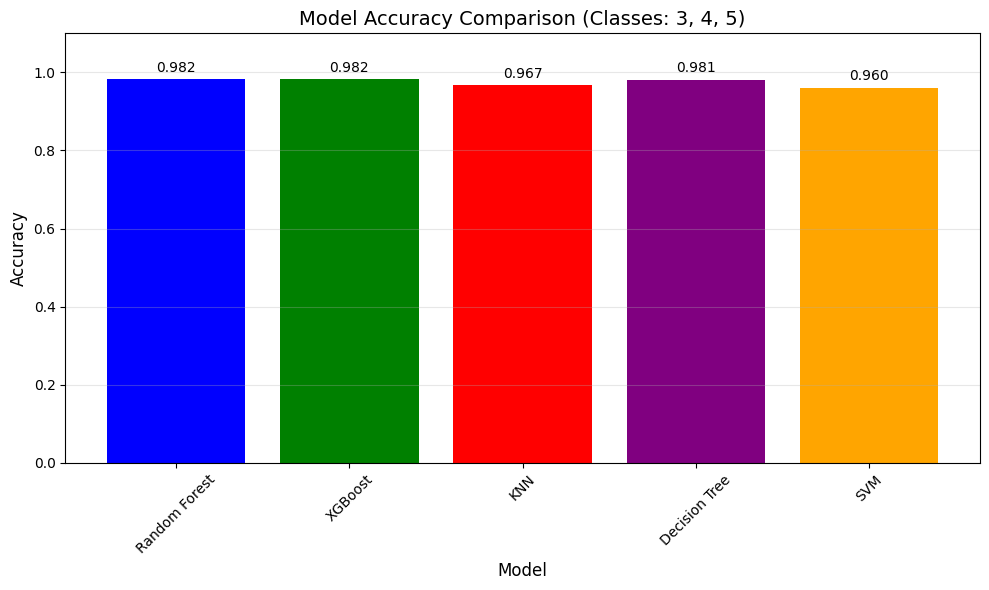

In [39]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_resampled)
class_names = le.classes_  
n_classes = len(class_names)

y_bin = label_binarize(y_encoded, classes=np.arange(n_classes))

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_bin, test_size=0.2, random_state=42
)

models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=60, max_depth=20, min_samples_split=3,
        min_samples_leaf=1, max_features=0.70, random_state=42,
        n_jobs=-1, oob_score=True, bootstrap=True
    ),
    "XGBoost": XGBClassifier(
        n_estimators=110, learning_rate=0.139, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, gamma=0.2,
        reg_alpha=0.5, reg_lambda=1.0,
        objective='multi:softprob',
        num_class=n_classes,
        use_label_encoder=False, eval_metric='mlogloss', random_state=42
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=1, weights='uniform', algorithm='ball_tree',
        leaf_size=30, p=1, metric='minkowski', n_jobs=None
    ),
    "Decision Tree": DecisionTreeClassifier(
        criterion='gini', splitter='best', max_depth=17,
        min_samples_split=2, min_samples_leaf=1,
        min_weight_fraction_leaf=0.0, max_features=None,
        random_state=42,  
        max_leaf_nodes=None,
        min_impurity_decrease=0.0, class_weight=None,
        ccp_alpha=0.0, monotonic_cst=None
    ),
    "SVM": SVC(
        kernel='rbf', C=100, degree=3, gamma='scale',
        coef0=1.11, probability=True, random_state=42
    )
}

accuracy_scores = {}
roc_data = {}

for name, model in models.items():
    y_train_indices = y_train.argmax(axis=1)
    model.fit(X_train, y_train_indices)
    y_pred = model.predict(X_test)
    
    y_test_indices = y_test.argmax(axis=1)
    accuracy_scores[name] = accuracy_score(y_test_indices, y_pred)
    
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)
        if y_score.ndim == 1:
            y_score = np.column_stack([-y_score, y_score])
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    roc_data[name] = {
        "fpr": fpr,
        "tpr": tpr,
        "roc_auc": roc_auc
    }

plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange']
linestyles = ['-', '--', ':', '-.', '-']

for idx, (name, data) in enumerate(roc_data.items()):
    plt.plot(data["fpr"]["micro"], data["tpr"]["micro"],
             color=colors[idx], linestyle=linestyles[idx],
             label=f'{name} (AUC = {data["roc_auc"]["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Micro-Averaged ROC Curve Comparison', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=colors)

for i, (name, acc) in enumerate(accuracy_scores.items()):
    plt.text(i, acc + 0.02, f"{acc:.3f}", ha='center', fontsize=10)

plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title(f"Model Accuracy Comparison (Classes: {', '.join(map(str, class_names))})", fontsize=14)
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Hard Voting doesn't support probability estimates, skipping ROC


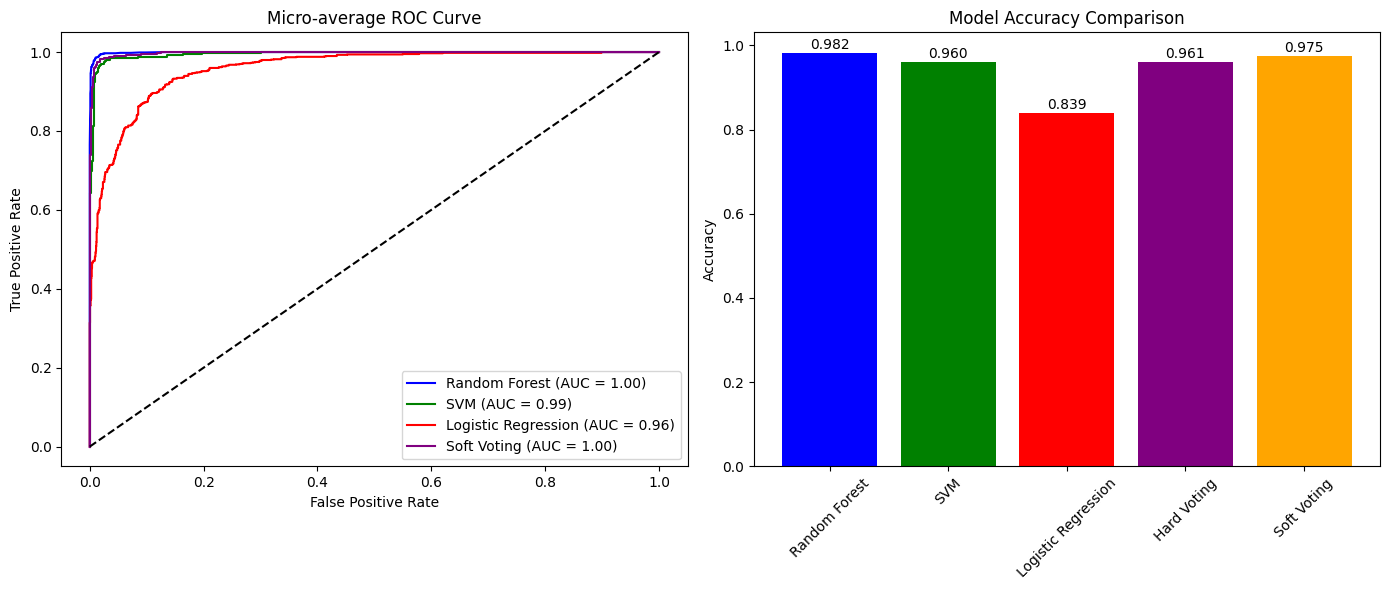

In [40]:
rf_model = RandomForestClassifier(
    n_estimators=60,         
    max_depth=20,             
    min_samples_split=3,      
    min_samples_leaf=1,       
    max_features=0.70,         
    random_state=42,          
    n_jobs=-1,                
    oob_score=True,           
    bootstrap=True            
)

svc_model = SVC(
    kernel='rbf',     
    C=100,             
    degree=3,          
    gamma='scale',     
    coef0=1.11, 
    probability=True,  
    random_state=42
)

lr_model = LogisticRegression(
    penalty='l2',         
    C=2.8,                
    solver='liblinear',  
    max_iter=5000, 
    random_state=42
)

hard_voting = VotingClassifier(
    estimators=[('rf', rf_model), ('svc', svc_model), ('lr', lr_model)],
    voting='hard',
    n_jobs=-1
)

soft_voting = VotingClassifier(
    estimators=[('rf', rf_model), ('svc', svc_model), ('lr', lr_model)],
    voting='soft',
    n_jobs=-1
)

models = {
    "Random Forest": rf_model,
    "SVM": svc_model,
    "Logistic Regression": lr_model,
    "Hard Voting": hard_voting,
    "Soft Voting": soft_voting
}

accuracy_scores = {}
roc_data = {}

for name, model in models.items():
    model.fit(X_train, y_train.argmax(axis=1))
    y_pred = model.predict(X_test)
    
    accuracy_scores[name] = accuracy_score(y_test.argmax(axis=1), y_pred)
    
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
        
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        roc_data[name] = {
            "fpr": fpr,
            "tpr": tpr,
            "roc_auc": roc_auc
        }
    else:
        print(f"{name} doesn't support probability estimates, skipping ROC")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
colors = ['blue', 'green', 'red', 'purple', 'orange']
for idx, (name, data) in enumerate(roc_data.items()):
    plt.plot(data["fpr"]["micro"], data["tpr"]["micro"],
             color=colors[idx], label=f'{name} (AUC = {data["roc_auc"]["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=colors)
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
for i, v in enumerate(accuracy_scores.values()):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()

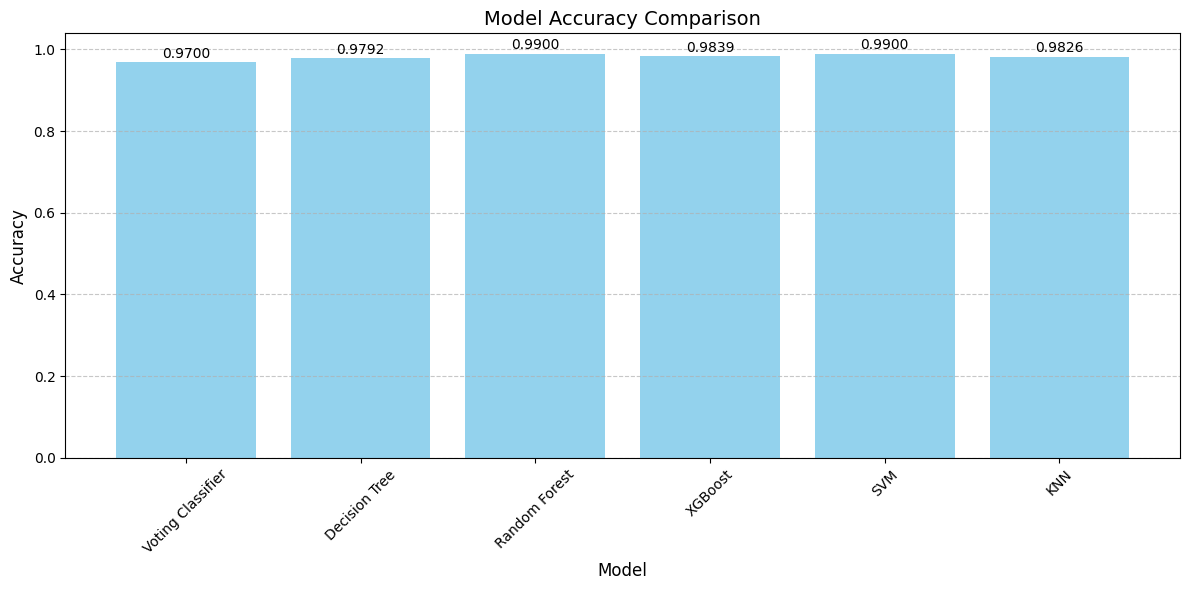

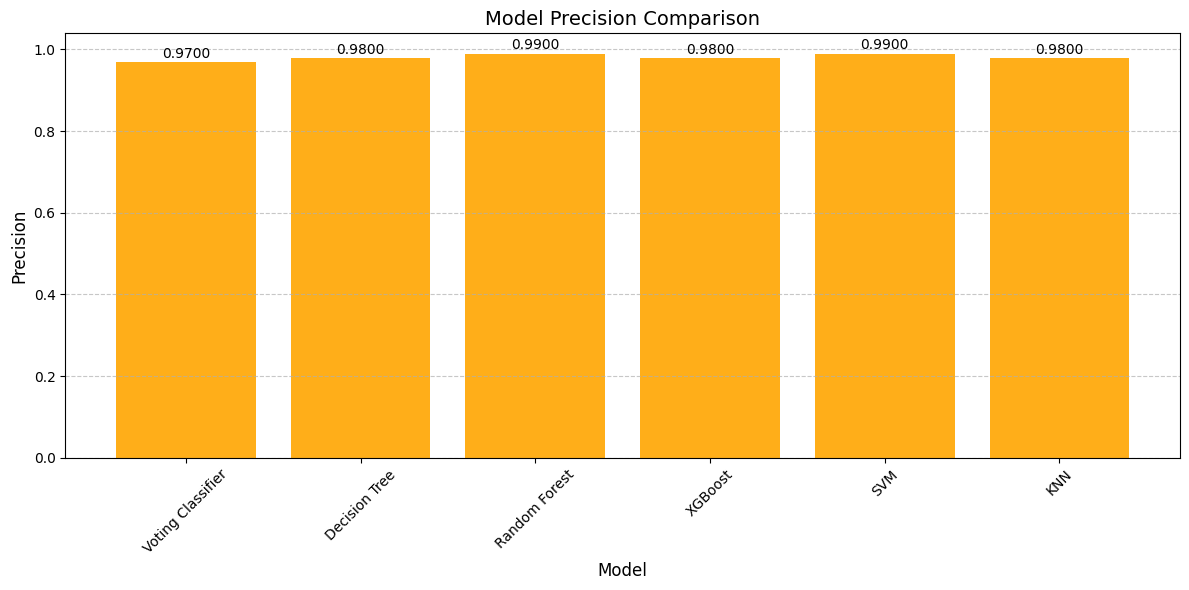

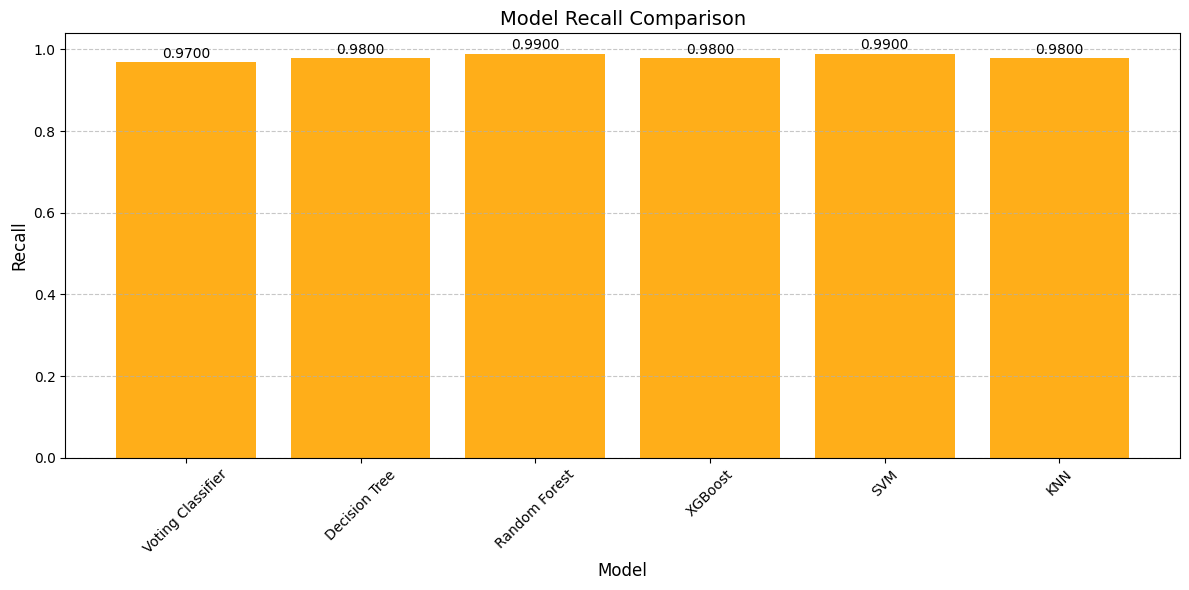

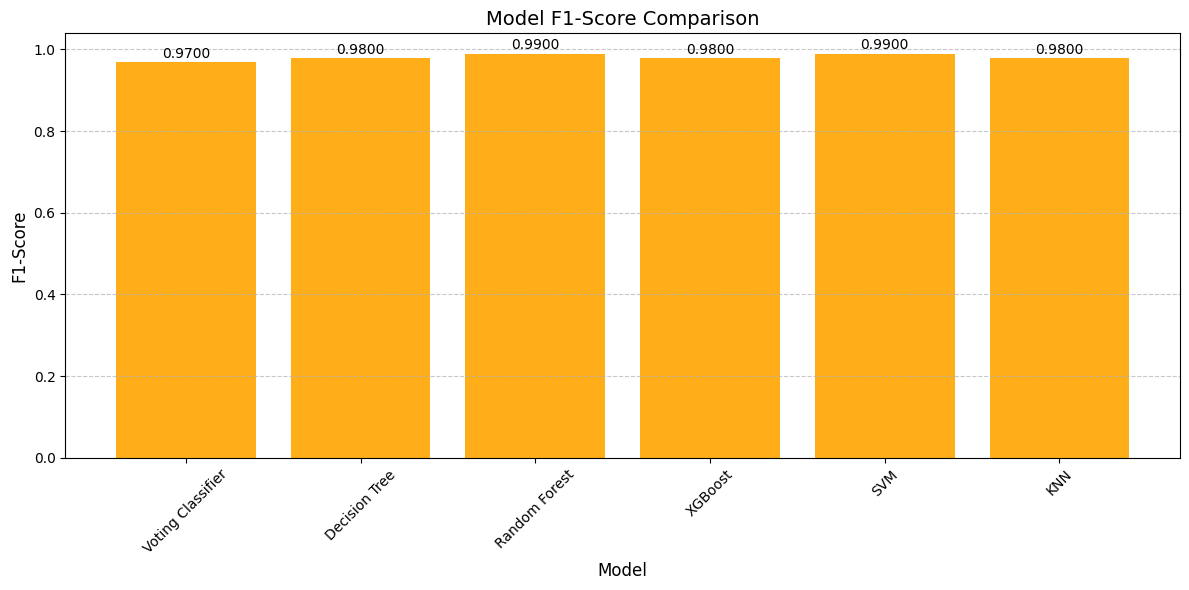

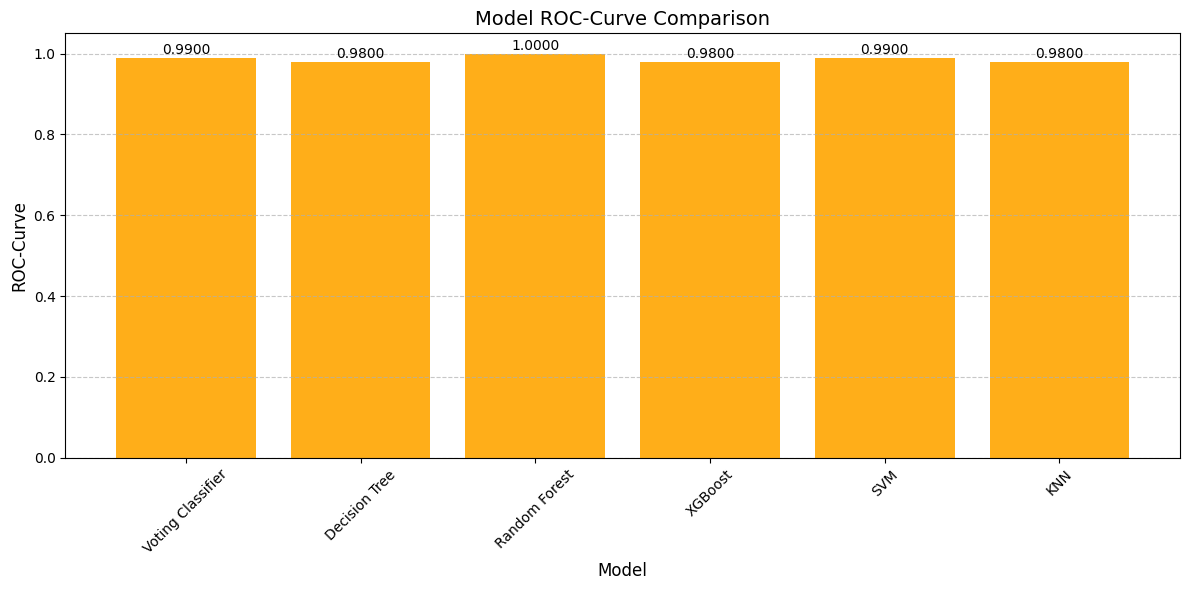

In [42]:
results_df = pd.DataFrame({
    'Model': [
        'Voting Classifier', 
        'Decision Tree', 
        'Random Forest', 
        'XGBoost', 
        'SVM', 
        'KNN'
    ],
    'Accuracy': [0.97, 0.9792, 0.99, 0.9839, 0.99, 0.9826],
    'Precision': [0.97, 0.98, 0.99, 0.98, 0.99, 0.98],
    'Recall': [0.97, 0.98, 0.99, 0.98, 0.99, 0.98],
    'F1-Score': [0.97, 0.98, 0.99, 0.98, 0.99, 0.98],
    'ROC-Curve': [0.99, 0.98, 1.00, 0.98, 0.99, 0.98]  
})

plt.figure(figsize=(12, 6))
plt.bar(results_df['Model'], results_df['Accuracy'], color='skyblue', alpha=0.9, label='Accuracy')
plt.title('Model Accuracy Comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(results_df['Accuracy']):
    plt.text(i, value + 0.01, f"{value:.4f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

metrics = ['Precision', 'Recall', 'F1-Score', 'ROC-Curve']
for metric in metrics:
    plt.figure(figsize=(12, 6))
    plt.bar(results_df['Model'], results_df[metric], color='orange', alpha=0.9, label=metric)
    plt.title(f'Model {metric} Comparison', fontsize=14)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for i, value in enumerate(results_df[metric]):
        plt.text(i, value + 0.01, f"{value:.4f}", ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()